In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU
import matplotlib.pyplot as plt
import time

# Download stock data
symbol = "SPY"
data = yf.download(symbol, start="2020-01-01", end="2023-09-01")
price_data = data[['Close']].values

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(price_data).reshape(-1,1))

# Split train and test set
train_size = int(len(scaled_data)*0.7) # 70% training, 30% testing
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:1]

def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

# calling the create dataset function to split the data into 
# input output datasets with time step 60
time_step = 60
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)


model = Sequential()
model.add(GRU(50,return_sequences = True,input_shape = (X_train.shape[1],1))) # input layer, 50 neurons and 1 for output 
model.add(GRU(50,return_sequences = True)) # hidden layer
model.add(GRU(50)) # hidden layer
model.add(Dense(1)) # output layers
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

model.summary()

[*********************100%***********************]  1 of 1 completed
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 60, 50)            7950      
                                                                 
 gru_7 (GRU)                 (None, 60, 50)            15300     
                                                                 
 gru_8 (GRU)                 (None, 50)                15300     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38601 (150.79 KB)
Trainable params: 38601 (150.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 8s 197ms/step - loss: 0.1539 - val_loss: 0.0568
Epoch 2/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0222 - val_loss: 0.0272
Epoch 3/100
10/10 [==============================] - 1s 83ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 4/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0070 - val_loss: 0.0039
Epoch 5/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 6/100
10/10 [==============================] - 1s 84ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 7/100
10/10 [==============================] - 1s 85ms/step - loss: 0.0019 - val_loss: 7.1958e-04
Epoch 8/100
10/10 [==============================] - 1s 87ms/step - loss: 0.0014 - val_loss: 7.1600e-04
Epoch 9/100
10/10 [==============================] - 1s 94ms/step - loss: 0.0011 - val_loss: 7.1699e-04
Epoch 10/100
10/10 [==============================] - 1s 90ms/step - loss: 9.7142e-04 -

Epoch 77/100
10/10 [==============================] - 1s 83ms/step - loss: 4.4547e-04 - val_loss: 3.2618e-04
Epoch 78/100
10/10 [==============================] - 1s 82ms/step - loss: 4.8071e-04 - val_loss: 4.0915e-04
Epoch 79/100
10/10 [==============================] - 1s 82ms/step - loss: 4.7933e-04 - val_loss: 3.5509e-04
Epoch 80/100
10/10 [==============================] - 1s 83ms/step - loss: 4.5111e-04 - val_loss: 3.1637e-04
Epoch 81/100
10/10 [==============================] - 1s 84ms/step - loss: 4.2151e-04 - val_loss: 3.4153e-04
Epoch 82/100
10/10 [==============================] - 1s 82ms/step - loss: 4.3233e-04 - val_loss: 3.9083e-04
Epoch 83/100
10/10 [==============================] - 1s 81ms/step - loss: 4.2859e-04 - val_loss: 3.6742e-04
Epoch 84/100
10/10 [==============================] - 1s 83ms/step - loss: 4.0535e-04 - val_loss: 3.5021e-04
Epoch 85/100
10/10 [==============================] - 1s 83ms/step - loss: 4.3354e-04 - val_loss: 3.1085e-04
Epoch 86/100
10/10 

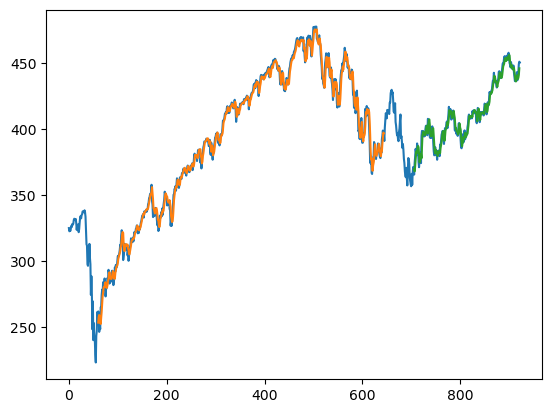

In [9]:
# check the running time
start_time = time.time()

model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1) # 100 epochs, 64 batch size

# end to check the time
end_time = time.time()

# print the running time
print("Learning time: ", end_time - start_time, "seconds")

# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Y_train and Y_test are in scaled form, so we need to transform them back to original scale
Y_train_orig = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_orig = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
print("Train RMSE:", np.sqrt(mean_squared_error(Y_train_orig, train_predict)))
print("Test RMSE:", np.sqrt(mean_squared_error(Y_test_orig, test_predict)))

## Plotting
look_back = 60

trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(scaled_data) - 1,:] = test_predict

plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() ## Orange is the TrainPredictPlot, Green is TestPredictPlot

In [10]:
# Define a range of batch sizes to experiment with
batch_sizes = [16, 32, 64, 128, 256]

# Store results for comparison
results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    # Define and compile the model
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(GRU(50, return_sequences=True))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=batch_size, verbose=1)

    # Prediction
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transform to original form
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(Y_train_orig, train_predict))
    test_rmse = np.sqrt(mean_squared_error(Y_test_orig, test_predict))

    print(f"Batch Size: {batch_size}, Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

    # Save results
    results.append((batch_size, train_rmse, test_rmse))

# Displaying results
for result in results:
    print(f"Batch Size: {result[0]}, Train RMSE: {result[1]}, Test RMSE: {result[2]}")


Training with batch size: 16
Epoch 1/100
37/37 [==============================] - 9s 95ms/step - loss: 0.0578 - val_loss: 0.0023
Epoch 2/100
37/37 [==============================] - 2s 61ms/step - loss: 0.0027 - val_loss: 6.7075e-04
Epoch 3/100
37/37 [==============================] - 2s 62ms/step - loss: 0.0011 - val_loss: 8.2970e-04
Epoch 4/100
37/37 [==============================] - 2s 64ms/step - loss: 8.1390e-04 - val_loss: 5.5043e-04
Epoch 5/100
37/37 [==============================] - 3s 70ms/step - loss: 7.4955e-04 - val_loss: 4.9378e-04
Epoch 6/100
37/37 [==============================] - 3s 71ms/step - loss: 6.8427e-04 - val_loss: 4.5308e-04
Epoch 7/100
37/37 [==============================] - 3s 69ms/step - loss: 6.8245e-04 - val_loss: 7.3997e-04
Epoch 8/100
37/37 [==============================] - 3s 69ms/step - loss: 7.1624e-04 - val_loss: 4.2164e-04
Epoch 9/100
37/37 [==============================] - 2s 63ms/step - loss: 6.5903e-04 - val_loss: 7.5328e-04
Epoch 10/100
3

37/37 [==============================] - 2s 63ms/step - loss: 4.7587e-04 - val_loss: 9.2939e-04
Epoch 77/100
37/37 [==============================] - 2s 65ms/step - loss: 4.1409e-04 - val_loss: 3.8510e-04
Epoch 78/100
37/37 [==============================] - 2s 65ms/step - loss: 4.0306e-04 - val_loss: 2.7474e-04
Epoch 79/100
37/37 [==============================] - 2s 66ms/step - loss: 3.5955e-04 - val_loss: 5.6024e-04
Epoch 80/100
37/37 [==============================] - 2s 65ms/step - loss: 5.0215e-04 - val_loss: 2.6433e-04
Epoch 81/100
37/37 [==============================] - 2s 65ms/step - loss: 3.5078e-04 - val_loss: 2.5711e-04
Epoch 82/100
37/37 [==============================] - 2s 64ms/step - loss: 3.6617e-04 - val_loss: 2.6188e-04
Epoch 83/100
37/37 [==============================] - 2s 65ms/step - loss: 3.9622e-04 - val_loss: 3.4908e-04
Epoch 84/100
37/37 [==============================] - 2s 65ms/step - loss: 3.6203e-04 - val_loss: 2.9903e-04
Epoch 85/100
37/37 [============

19/19 [==============================] - 2s 87ms/step - loss: 4.5532e-04 - val_loss: 3.0398e-04
Epoch 50/100
19/19 [==============================] - 2s 80ms/step - loss: 5.0523e-04 - val_loss: 4.6684e-04
Epoch 51/100
19/19 [==============================] - 2s 83ms/step - loss: 4.2103e-04 - val_loss: 3.4255e-04
Epoch 52/100
19/19 [==============================] - 2s 81ms/step - loss: 4.3294e-04 - val_loss: 3.1293e-04
Epoch 53/100
19/19 [==============================] - 2s 82ms/step - loss: 4.0990e-04 - val_loss: 2.9935e-04
Epoch 54/100
19/19 [==============================] - 2s 81ms/step - loss: 3.8576e-04 - val_loss: 3.5582e-04
Epoch 55/100
19/19 [==============================] - 2s 82ms/step - loss: 3.9682e-04 - val_loss: 2.9351e-04
Epoch 56/100
19/19 [==============================] - 1s 79ms/step - loss: 4.2276e-04 - val_loss: 3.0561e-04
Epoch 57/100
19/19 [==============================] - 2s 84ms/step - loss: 4.1036e-04 - val_loss: 3.1649e-04
Epoch 58/100
19/19 [============

Epoch 23/100
10/10 [==============================] - 1s 84ms/step - loss: 6.4850e-04 - val_loss: 4.6036e-04
Epoch 24/100
10/10 [==============================] - 1s 84ms/step - loss: 6.4569e-04 - val_loss: 4.4080e-04
Epoch 25/100
10/10 [==============================] - 1s 84ms/step - loss: 6.3323e-04 - val_loss: 5.2081e-04
Epoch 26/100
10/10 [==============================] - 1s 85ms/step - loss: 6.7199e-04 - val_loss: 4.5007e-04
Epoch 27/100
10/10 [==============================] - 1s 85ms/step - loss: 5.9803e-04 - val_loss: 4.3566e-04
Epoch 28/100
10/10 [==============================] - 1s 80ms/step - loss: 5.9107e-04 - val_loss: 4.2170e-04
Epoch 29/100
10/10 [==============================] - 1s 85ms/step - loss: 5.8420e-04 - val_loss: 4.2747e-04
Epoch 30/100
10/10 [==============================] - 1s 82ms/step - loss: 6.1457e-04 - val_loss: 4.1166e-04
Epoch 31/100
10/10 [==============================] - 1s 83ms/step - loss: 5.7720e-04 - val_loss: 4.0876e-04
Epoch 32/100
10/10 

10/10 [==============================] - 1s 93ms/step - loss: 3.9169e-04 - val_loss: 2.9127e-04
Epoch 99/100
10/10 [==============================] - 1s 94ms/step - loss: 4.0268e-04 - val_loss: 2.9659e-04
Epoch 100/100
7/7 [==============================] - 0s 16ms/step
Batch Size: 64, Train RMSE: 5.243957492581371, Test RMSE: 4.716712336629654

Training with batch size: 128
Epoch 1/100
5/5 [==============================] - 12s 732ms/step - loss: 0.3395 - val_loss: 0.0812
Epoch 2/100
5/5 [==============================] - 2s 330ms/step - loss: 0.0280 - val_loss: 0.0466
Epoch 3/100
5/5 [==============================] - 2s 325ms/step - loss: 0.0446 - val_loss: 0.0048
Epoch 4/100
5/5 [==============================] - 2s 308ms/step - loss: 0.0075 - val_loss: 0.0190
Epoch 5/100
5/5 [==============================] - 2s 311ms/step - loss: 0.0184 - val_loss: 0.0116
Epoch 6/100
5/5 [==============================] - 2s 311ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 7/100
5/5 [==========

5/5 [==============================] - 2s 324ms/step - loss: 5.0174e-04 - val_loss: 3.6990e-04
Epoch 74/100
5/5 [==============================] - 2s 332ms/step - loss: 4.9648e-04 - val_loss: 3.6332e-04
Epoch 75/100
5/5 [==============================] - 2s 311ms/step - loss: 4.8995e-04 - val_loss: 3.6076e-04
Epoch 76/100
5/5 [==============================] - 2s 314ms/step - loss: 4.9211e-04 - val_loss: 3.6427e-04
Epoch 77/100
5/5 [==============================] - 2s 311ms/step - loss: 5.0540e-04 - val_loss: 3.5751e-04
Epoch 78/100
5/5 [==============================] - 2s 313ms/step - loss: 4.9253e-04 - val_loss: 3.5609e-04
Epoch 79/100
5/5 [==============================] - 2s 310ms/step - loss: 4.8352e-04 - val_loss: 3.5920e-04
Epoch 80/100
5/5 [==============================] - 2s 307ms/step - loss: 4.8228e-04 - val_loss: 3.5361e-04
Epoch 81/100
5/5 [==============================] - 2s 320ms/step - loss: 4.7753e-04 - val_loss: 3.5572e-04
Epoch 82/100
5/5 [=======================

Epoch 49/100
3/3 [==============================] - 1s 223ms/step - loss: 7.0769e-04 - val_loss: 4.8883e-04
Epoch 50/100
3/3 [==============================] - 1s 216ms/step - loss: 7.0083e-04 - val_loss: 4.8787e-04
Epoch 51/100
3/3 [==============================] - 1s 216ms/step - loss: 6.9667e-04 - val_loss: 4.8705e-04
Epoch 52/100
3/3 [==============================] - 1s 217ms/step - loss: 6.9108e-04 - val_loss: 4.7872e-04
Epoch 53/100
3/3 [==============================] - 1s 225ms/step - loss: 6.8790e-04 - val_loss: 4.7686e-04
Epoch 54/100
3/3 [==============================] - 1s 224ms/step - loss: 6.8629e-04 - val_loss: 4.7436e-04
Epoch 55/100
3/3 [==============================] - 1s 219ms/step - loss: 6.8091e-04 - val_loss: 4.8598e-04
Epoch 56/100
3/3 [==============================] - 1s 220ms/step - loss: 6.7780e-04 - val_loss: 4.7152e-04
Epoch 57/100
3/3 [==============================] - 1s 226ms/step - loss: 6.6870e-04 - val_loss: 4.6536e-04
Epoch 58/100
3/3 [==========